# Flatiron Health mCRC: Discriminatory performance of models 

**OBJECTIVE: Time-dependent AUC for test set patients from 1 month to 36 months after metastatic diagnosis will be plotted for each survival machine learning model and the traditional Cox model.**

## 1. Discriminatory performance

**The measure used to evaluate model performance is time-dependent area under the receiver operator curve (AUC) at 1 year. This metric determines how well a model can distinguish patients who die by time *t* from patients who die after this time. Our focus is to assess model discriminatory performance within the first couple years from metastatic diagnosis. Time dependent AUC was selected instead of the more frequently used metric in survival data, concordance index, since the concordance index is not time dependent and thus assess models performance over the entire range of survival times which in our case would be 10 years.** 

**The time point 1 year from advanced diagnosis was selected as the primary time-point of interest and so all machine learning model hyperparamters are tuned to maximize performance at that time point. Secondary time points of interest include 6-months and 2-years from advanced idagnosis and will also be calculated for each model.** 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm

In [2]:
# Import CSV files 

#Import GBM MICE test AUCs over 2 years
mice_auc_over5 = pd.read_csv('mice_auc_over5.csv', index_col = 0)

# Import machine learning and BMJ crude test AUCs over 5 years 
crude_auc_over5 = pd.read_csv('crude_auc_over5.csv', index_col = 0)

# Import BMJ MICE test AUCs over 2 years 
cox_auc_over5 = pd.read_csv('cox_auc_over5.csv', index_col = 0)

# Import table of AUC at 1 year for all models  
all_models_auc_df = pd.read_csv('all_models_auc_df.csv')

# Import GBM MICE coefficients
coefficients_mice = pd.read_csv('coefficients_mice.csv')

In [3]:
# Dataframe of average coefficient for variables for all GBM MICE models 
top_coef = (
    coefficients_mice
    .groupby('variable')['coefficient'].mean()
    .to_frame()
    .sort_values(by = 'coefficient', ascending = False)
    .reset_index()
)

In [4]:
# Processing names of variables for plot 
top_coef.at[0, 'variable'] = 'Weight, slope'
top_coef.at[1, 'variable'] = 'Age'
top_coef.at[2, 'variable'] = 'Albumin'
top_coef.at[3, 'variable'] = 'ECOG'
top_coef.at[4, 'variable'] = 'ALP'
top_coef.at[5, 'variable'] = 'CEA'
top_coef.at[7, 'variable'] = 'ALP, maximum'
top_coef.at[8, 'variable'] = 'Chloride'
top_coef.at[9, 'variable'] = 'WBC, minimum'
top_coef.at[10, 'variable'] = 'BMI'
top_coef.at[11, 'variable'] = 'Albumin, minimum'
top_coef.at[12, 'variable'] = 'Hemoglobin'
top_coef.at[14, 'variable'] = 'WBC'
top_coef.at[15, 'variable'] = 'Metastasis free interval'
top_coef.at[16, 'variable'] = 'Total bilirubin, maximum'

In [5]:
top_coef = top_coef.iloc[[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16], :]

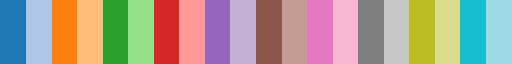

In [6]:
cm = plt.get_cmap('tab20')
cm

In [7]:
# Rounding fucntion
def truncate(n, decimals = 0):
    multiplier = 10 ** decimals
    return int(n * multiplier) / multiplier

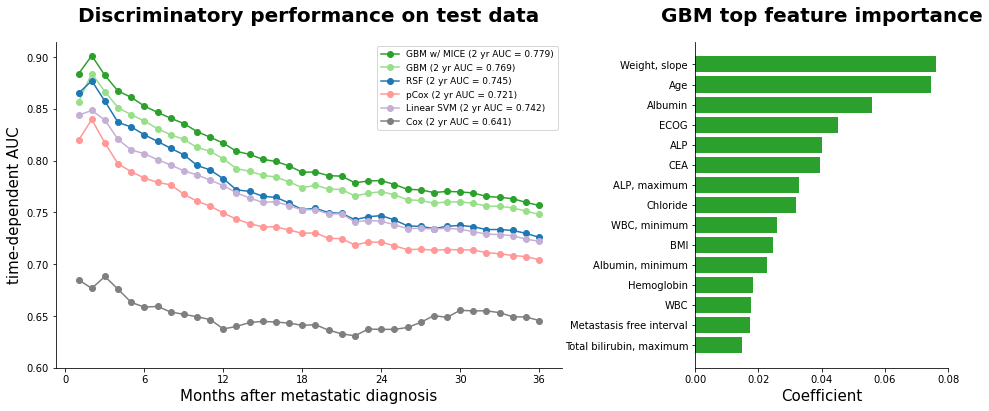

In [8]:
fig = plt.figure()

fig.set_figheight(6)
fig.set_figwidth(16)

spec = gridspec.GridSpec(ncols = 2, nrows = 1, width_ratios = [2, 1], wspace = 0.35)

# Discriminatory performance plot
times = np.arange(30, 1090, 30)

ax0 = fig.add_subplot(spec[0])

ax0.plot(times/30, mice_auc_over5.mean().values[0:36], 'o-', color = cm.colors[4], label = 'GBM w/ MICE (2 yr AUC = {})'.format(round(all_models_auc_df.query('model == "gbm_mice"').auc_2yr_te.values[0], 3))) 

ax0.plot(times/30, crude_auc_over5.loc['gbm_crude'].values[0:36], 'o-', color = cm.colors[5], label = 'GBM (2 yr AUC = {})'.format(round(all_models_auc_df.query('model == "gbm_crude"').auc_2yr_te.values[0], 3)))

ax0.plot(times/30, crude_auc_over5.loc['rsf_crude'].values[0:36], 'o-', color = cm.colors[0], label = 'RSF (2 yr AUC = {})'.format(round(all_models_auc_df.query('model == "rsf_crude"').auc_2yr_te.values[0], 3)))

ax0.plot(times/30, crude_auc_over5.loc['enet_crude'].values[0:36], 'o-', color = cm.colors[7], label = 'pCox (2 yr AUC = {})'.format(round(all_models_auc_df.query('model == "enet_crude"').auc_2yr_te.values[0], 3)))

ax0.plot(times/30, crude_auc_over5.loc['linear_svm_crude'].values[0:36], 'o-', color = cm.colors[9], label = 'Linear SVM (2 yr AUC = {})'.format(round(all_models_auc_df.query('model == "linear_svm_crude"').auc_2yr_te.values[0], 3)))

ax0.plot(times/30, cox_auc_over5.loc['cox_cc'].values[0:36], 'o-', color = cm.colors[14], label = 'Cox (2 yr AUC = {})'.format(round(all_models_auc_df.query('model == "cox_crude"').auc_2yr_te.values[0], 3)))

ax0.set_xticks(np.arange(0, 37, 6))
ax0.set_yticks(np.arange(0.60, 0.90, 0.05))

ax0.set_title('Discriminatory performance on test data', weight = 'bold', size = 20, pad = 20)
ax0.set_xlabel('Months after metastatic diagnosis', size = 15)
ax0.set_ylabel('time-dependent AUC', size = 15)
ax0.legend(loc = 'upper right', prop = {'size': 9})

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# GBM feature importance plot
ax1 = fig.add_subplot(spec[1])

ax1.barh(top_coef['variable'], top_coef['coefficient'], color = cm.colors[4])
ax1.set_yticks(top_coef['variable'], )
ax1.invert_yaxis()

ax1.set_title('GBM top feature importance', weight = 'bold', size = 20, pad = 20)
ax1.set_xlabel('Coefficient', size = 15)
#ax1.text(0.08, 14, 'Total number of features: '+str(len(coefficients_gbm.query('coefficient != 0'))), fontsize = 10, bbox = dict(facecolor = 'white'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.savefig('auc_plot_models.png', bbox_inches = 'tight')

plt.show()